# How to execute other workflows in a SoS step

* **Difficulty level**: intermediate
* **Time need to lean**: 10 minutes or less
* **Key points**:
  * Action `sos_run` execute a workflow
  * Multiple workflows can be executed in parallel if they are specified as a list to action `sos_run`
  

###  Action `sos_run`

Action `sos_run(workflow=None, targets=None, shared=[], source=None, args={}, **kwargs)` executes a specified workflow from the current (default) or specified SoS script (`source`). The workflow can be a single workflow, a subworkflow (e.g. `A_-10`), a combined workflow (e.g. `A + B`), or a workflow that is constructed to generate `targets`. The workflow

* Takes `_input` of the parental step as the input of the first step of the subworkflow
* Takes `args` (a dictionary) and `**kwargs` as parameters as if they are specified from command line
* Copies variables specified in `shared` (a string or a list of string) to the subworkflow if they exist in the parental namespace
* Returns variables defined in `shared` to the parental namespace after the completion of the workflow

`sos_run` would be executed in a separate process in batch mode, and would be executed in the same process in interactive mode, so parameter `shared` is only needed for batch execution.

The simplest use of action `sos_run` is for the execution of one or more workflows. For example,

In [26]:
%run
[A]
print(step_name)

[B]
print(step_name)

[default]
sos_run('A + B')

A_0
B_0


The subworkflows are executed separately and only takes the `_input` of the step as the `input` of the workflow. For example,

In [27]:
%sandbox
%run
!touch a.txt b.txt

[process]
print(f"Handling {_input}")

[default]
input: 'a.txt', 'b.txt', group_by=1
sos_run('process')

Handling a.txt
Handling b.txt


If you would like to send one or more variables to the subworkflow or return a variable from the execution of subworkflow, you can specify them with the `shared` variable. The return variable part is a bit tricky here because you can only return workflow level variable that are usually `shared` from a step of the subworkflow. For example,

In [28]:
%sandbox
%run

[process]
print(f"Working with seed {seed}")

[default]
for seed in range(5):
    sos_run('process', seed=seed)

Working with seed 0
Working with seed 1
Working with seed 2
Working with seed 3
Working with seed 4


In [29]:
%sandbox
%run

[process: shared='result']
result = 100

[default]
sos_run('process')
print(f"Result from subworkflow process is {result}")
    

Result from subworkflow process is 100


If the subworkflow accepts parameters, they can be specified using keyword arguments or as a dictionary for parameter `args` of the `sos_run` function. The subworkflow would take values from parameters as if they are passed from command line. 

For example, the following workflow defines parameter `cutoff` with default value 10. When it is executed without command line option, the default value is used.

In [30]:
%sandbox
%run

[default]
parameter: cutoff=10
print(f"Process with cutoff={cutoff}")

[batch]
for value in range(2, 10, 2):
    sos_run('default', cutoff=value)

Process with cutoff=10


Command line argument could be used to specify a different `cutoff` value:

In [31]:
%sandbox
%rerun --cutoff 4

Process with cutoff=4


Now, if we run the `batch` workflow, which calls the `default` workflow with parameter `cutoff`, the `parameter: cutoff=10` statement takes the passed value as if it were specified from command line.

In [32]:
%sandbox
%rerun batch

Process with cutoff=2
Process with cutoff=4
Process with cutoff=6
Process with cutoff=8


Note that the parameters could also be specified with parameter `args`, 

In [33]:
%sandbox
%run batch

[default]
parameter: cutoff=10
print(f"Process with cutoff={cutoff}")

[batch]
for value in range(2, 10, 2):
    sos_run('default', args={'cutoff': value})

Process with cutoff=2
Process with cutoff=4
Process with cutoff=6
Process with cutoff=8


although the keyword arguments are usually easier to use.

Action `sos_run` cannot be used in `task` (see [Remote Execution](Remote_Execution.html) for details) because tasks are designed to be executed independently of the workflow. 

### Nested workflow (`sos_run`) <a id="Nested_workflow_sos_run"></a>

SoS also supports nested workflow in which a complete workflow is treated as part of a step process.
The workflow is execute by SoS action `sos_run`, e.g.

```python
sos_run('A')            # execute workflow A
sos_run('A + B')        # execute workflow B after A
sos_run('D:-10 + C')    # execute up to step 10 of D and workflow C

# execute user-specified aligner and caller workflows
sos_run(f'{aligner} + {caller}')  
```

In its simplest form, nested workflow allows you to define another workflow from existing ones. For example,

align_10
align_20
call_10
call_20


> forward.dot (1.5 KiB):

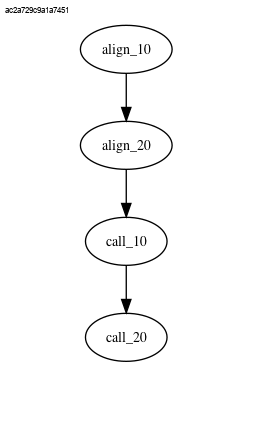

In [78]:
%preview -n forward.dot
%run -d forward.dot
[align_10]
print(step_name)
[align_20]
print(step_name)
[call_10]
print(step_name)
[call_20]
print(step_name)
[default]
sos_run('align+call')

defines a nested workflow that combines workflows `align` and `call` so that the workflow will by default execute two workflows, but can also execute one of them as separate workflows `align` and `call`. This example also uses option `-d` to output the execution path of the workflow to a file, and magic `%preview` to preview the path.

Nested workflow also allows you to define multiple mini-workflows and connect them freely. For example

```python
[a_1]
[a_2]
[b]
[c]
[d_1]
sos_run('a+b')
[d_2]
sos_run('a+c')
```

defines workflows `d` that will execute steps `d_1`, `a_1`, `a_2`, `b_0`, `d_2`,  `a_1`, `a_2`, and `c_0`. 

A `parameter` statement usually gets its value from command line. However, when a workflow is executed as a subworkflow by action `sos_run`, the `parameter` statement can get its value from the `args` or `**kwargs` parameters of `sos_run`.

For example, when the `default` workflow of the following script is executed, `cutoff` takes its default value of `10`. 

In [79]:
%run
[default_1]
parameter: cutoff=10
run: expand=True
  echo {cutoff}

[batch]
for cutoff in range(3):
    sos_run('default', cutoff=cutoff)

echo 10
10



A command line argument can be used to set this parameter to `8`,

In [80]:
%rerun --cutoff 8

echo 8
8



Now, if the workflow is called as a subworkflow of step `batch`, `sos_run` set up the environment so that the statement `parameter: cutoff=10` gets a different cutoff value pass by  `sos_run`.

In [81]:
%rerun batch 

echo 0
0

echo 1
1

echo 2
2



Because `sos_run` is simply a SoS action and takes a string as its parameter, it allows very flexible ways to compose (e.g. determine workflow from command line arguments) and execute (e.g. repeated execution of workflows with different options or input files) complex workflows. Furthermore, the workflows can be defined in another file so you can organize your workflow as a master workflow that calls nested workflows defined in other files.

For example, suppose we create a workflow with two steps:

In [82]:
%preview -n nested.sos
%run

[10]
report: output='nested.sos'
  [nested_20]
  print(f"This is {step_name} of a nested workflow")
  
  [nested_30]
  print(f"This is {step_name} of a nested workflow")


> nested.sos (128 B):

[nested_20]
print(f"This is {step_name} of a nested workflow")

[nested_30]
print(f"This is {step_name} of a nested workflow")


Then, we can execute this workflow with a `sos_run` action as follows

In [83]:
sos_run('nested', source='nested.sos')

This is nested_20 of a nested workflow
This is nested_30 of a nested workflow


## Further reading

* 